# Identyfikacja oddziaływań neutrin w detektorach ciekłoargonowych metodami uczenia maszynowego

## 3. Preprocessing i uczenie

Pliki tau_data.csv i mu_data.csv przygotowane zgodnie ze skryptem eksport_danych.ipynb zawierają informację o rodzaju, pędach i energii każdego z naładowanych końcowych produktów oddziaływań. Pliki te należy wczytać oraz umieścić dane dotyczące każdego z oddziaływań w osobnej macierzy biblioteki numpy. Następnie cząstki o zbyt niskim pędzie są odrzucane i selekcjonowane są jedynie oddziaływania o dwóch produktach końcowych. Ostatecznym wynikiem jest lista macierzy o rozmiarze 2x6 gdzie drugi wiesz zawiera odpowiednio kod pdg, pęd całkowity, pęd poprzeczny oraz pędy w trzech kierunkach mionu, a pierwszy takie same parametry drugiego produktu oddziaływania.

In [1]:
import numpy as np
import csv

#Funkcja przyjmuje plik .csv w którym każdy wiersz to [nr, pid1, px1, py1, pz1, E1, pid2, px2, py2, pz2, E2] itd. dla wszystkich naładowanych
#produktów końcowych
def loading_data(file):
    with open(file, 'r') as f:
        final_data = []
        reader = csv.reader(f)
        for row in reader:
            event = []
            particles = np.array(row[1:], dtype=float).reshape(-1, 5) #Tworzenie macierzy w której każdy wiersz to kod, pędy i energia kolejnej cząstki
            #particles = particles[~np.all(particles[:, 1:] == 0., axis=1)] #Odrzucenie cząstek o pędach zerowych pojawiających sie w wygenerowanym pliku
            if 13 in particles[:, 0]: #Wykorzystujemy tylko oddziaływania, w których wśród produktów występuje mion
                for particle in particles:
                    pid, px, py, pz, E = particle
                    momentum = np.linalg.norm([px, py, pz])
                    xy_momentum = np.linalg.norm([px, py])
                    if pid in [-211, 211, 321, -321, 13]: #piony, kaony i mion
                        border_momentum = 0.01
                    else:
                        border_momentum = 0.26
                    if momentum > border_momentum:
                        event.append([pid, momentum, xy_momentum, pz, px, py])
                if len(event) == 2:
                    event = np.array(event)
                    if event[:, 0][0] == 13:
                        event = event[[1, 0]] # Każda macierz zawiera parametry mionu w drugim wierszu
                    final_data.append(np.array(event)) #final_data to lista macierzy oddziaływań
    return final_data 

In [2]:
raw_tau_data = loading_data('tau_data.csv')
raw_mu_data = loading_data('mu_data.csv')

W następnej kolejności dochodzi do wprowadzenia efektywności detekcji ze względu na kąt między cząstkami oraz zapisania danych w formie w jakiej będą używane do trenowania modelu

In [3]:
# Funkcja do liczenia kąta między dwoma wektorami
def angle(a, b):
    dot_product = np.dot(a, b)
    length_a = np.linalg.norm(a)
    length_b = np.linalg.norm(b)
    return np.arccos(dot_product / (length_a * length_b))

# Funkcja sprawdzająca efektwyność detekcji ze względu na kąt między dwoma cząstkami
def angle_detection_efficiency(input_data, angle_func):
    limited_data = []
    for entry in input_data:
        event = entry.copy()
        alpha = angle_func(event[0][3:6], event[1][3:6]) # Obliczanie kąta między cząstkami w macierzy
        if 0.3 < alpha < 2.8:
            theta = angle_func([1, 0, 0], event[1][3:6]) # Obliczanie kąta między mionem i osią OZ którą poruszało się neutrino
            event = event[:,1:4] # Obcinanie danych w macierzach jedynie do pędu całkowitego, poprzecznego i podłużnego
            event = np.append(event, alpha).reshape(1, 7)
            event = np.append(event, theta).reshape(1, 8) # Macierz zostaje spłaszczona do jednego wiersza z obydwoma kątami dodanymi na końcu
            limited_data.append(event)
    return limited_data

In [4]:
cut_tau_data = angle_detection_efficiency(raw_tau_data, angle)
cut_mu_data = angle_detection_efficiency(raw_mu_data, angle)

Przygotowane dane trzeba podzielić na dane testowe oraz treningowe w odpowiednich proporcjach sygnału i tła, a także stworzyć zbiór celów dla modelu wskazujący do której grupy powinno być przyporządkowane każde z oddziaływań

In [5]:
import random
from tensorflow.keras.utils import to_categorical

# Funkcja rozdzielająca dane na test i train dataset o zadanych wielkościach oraz tworząca inputy i targety dla modelu 
def train_test_split(signal_dataset, bg_dataset, train_size, test_size, equal_split):
    signal_percent = len(signal_dataset) / (len(bg_dataset) + len(signal_dataset)) # Rzeczywisty stosunek sygnału do tła
    print(f' signal to background percent = {round(signal_percent * 100, 2)} %')
    test_signal_size = int(test_size * signal_percent) # Ilość sygnału w zbiorze testowym
    test_bg_size = int(test_size - test_signal_size) # Ilość tła w zbiorze testowym
    if equal_split: # equal_split określa sytaucje kiedy w danych do uczenia wystepuje równy stosunek sygnału do tła
        train_signal_size = int(train_size / 2)
        train_bg_size = int(train_size / 2)
    else:
        train_signal_size = int(train_size * signal_percent)
        train_bg_size = int(train_size - train_signal_size)
    print(f' train signal size = {train_signal_size}\n train background size = {train_bg_size}')
    print(f' test signal size = {test_signal_size}\n test background size = {test_bg_size}')
    bg_sample = random.sample(bg_dataset, k = train_bg_size + test_bg_size) # Wybieranie losowej próby o zadanym rozmiarze spośród danych
    signal_sample = random.sample(signal_dataset, k = train_signal_size + test_signal_size)
    test_inputs = signal_sample[0:test_signal_size] + bg_sample[0:test_bg_size] # Tworzenie zbioru testowego
    test_targets = [1 for event in range(test_signal_size)] + [0 for event in range(test_bg_size)] # Tworzenie celów dla testów 1-sygnał, 0-tło
    train_inputs = signal_sample[test_signal_size:] + bg_sample[test_bg_size:] # Tworzenie zbioru treningowego
    train_targets = [1 for event in range(train_signal_size)] + [0 for event in range(train_bg_size)] # Tworzenie celów dla uczenia 1-sygnał, 0-tło
    return test_inputs, train_inputs, test_targets, train_targets, test_signal_size

# Funkcja służąca wymieszaniu danych w zbiorze treningowym oraz kowersji celów do treningu do optymalnego formatu dla TensorFlow 
def shuffling(input_data, target_data):
    temp = list(zip(input_data, target_data))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    all_inputs, targets = np.array(res1), np.array(res2)
    targets = to_categorical(targets, num_classes=2)
    return all_inputs, targets

In [6]:
train_size = 100000 # Łączna liczba zdarzeń w próbie treningowej podzielona na tło i sygnał
test_size = 200000 # Łączna liczba zdarzeń w próbie testowej podzielona na tło i sygnał
equal_split = True # Czy stosunek sygnału do tła ma być równy w przypadku treningu

In [7]:
test_all_inputs, raw_train_inputs, test_targets, raw_train_targets, test_signal_size = train_test_split(cut_tau_data, cut_mu_data, 
                                                                                                        train_size, test_size, equal_split)
train_all_inputs, train_targets = shuffling(raw_train_inputs, raw_train_targets)
# Usuwanie ze zbiorów pędów całkowitych cząstek - nie są potrzebne do treningu, jedynie w dalszej części do wykreślania zależności wyników
test_inputs = np.delete(test_all_inputs, [0, 3], 2) 
train_inputs = np.delete(train_all_inputs, [0, 3], 2)

 signal to background percent = 14.14 %
 train signal size = 50000
 train background size = 50000
 test signal size = 28275
 test background size = 171725


Do uczenia używana jest sieć neuronowa o zadanej liczbie ukrytych warstw o wybranych szerokościach oraz funkcjach aktywujących. Warstwa wyjściowa zawsze aktywowana jest funkcją softmax zwracającą wynik w formie prawdopodobieństwa.

In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight


def build_dnn_model(N, M, sizes, act):
    layers_list = [layers.Input(shape=(N, M)), layers.Flatten()]
    for size in range(len(sizes)):
        layers_list.append(layers.Dense(sizes[size], activation=act))
    layers_list.append(layers.Dense(2, activation="softmax"))
    model = models.Sequential(layers_list)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])
    return model

In [9]:
sizes = [512, 256, 128] # Lista szerokości kolejnych ukrytych warstw sieci
activation = "relu" # Funkcja aktywacji dla każdej z ukrytych warstw
wagi = np.array([0, 1]) # Ustalanie wag dla sygnału i tła - im więcej 0 w liście tym wyższa waga przypisana sygnałowi

In [10]:
N = train_inputs.shape[1]
M = train_inputs.shape[2] 
dnn_model = build_dnn_model(N, M, sizes, activation)
dnn_model.summary()
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(wagi), y=wagi)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
dnn_model.fit(train_inputs, train_targets, batch_size=50, epochs=10, validation_split=0.2, class_weight=class_weight_dict, verbose=2)
dnn_results = dnn_model.predict(test_inputs)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,066 (656.51 KB)

 Trainable params: 168,066 (656.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1600/1600 - 7s - 4ms/step - accuracy: 0.8378 - loss: 0.3641 - val_accuracy: 0.8565 - val_loss: 0.3341
Epoch 2/10
1600/1600 - 6s - 4ms/step - accuracy: 0.8663 - loss: 0.3118 - val_accuracy: 0.8645 - val_loss: 0.3172
Epoch 3/10
1600/1600 - 5s - 3ms/step - accuracy: 0.8735 - loss: 0.3005 - val_accuracy: 0.8699 - val_loss: 0.3034
Epoch 4/10
1600/1600 - 5s - 3ms/step - accuracy: 0.8767 - loss: 0.2938 - val_accuracy: 0.8668 - val_loss: 0.3130
Epoch 5/10
1600/1600 - 5s - 3ms/step - accuracy: 0.8771 - loss: 0.2914 - val_accuracy: 0.8711 - val_loss: 0.3006
Epoch 6/10
1600/1600 - 5s - 3ms/step - accuracy: 0.8788 - loss: 0.2873 - val_accuracy: 0.8761 - val_loss: 0.2957
Epoch 7/10
1600/1600 - 5s - 3ms/step - accuracy: 0.8793 - loss: 0.2854 - val_accuracy: 0.8741 - val_loss: 0.2962
Epoch 8/10
1600/1600 - 5s - 3ms/step - accuracy: 0.8813 - loss: 0.2820 - val_accuracy: 0.8789 - val_loss: 0.2853
Epoch 9/10
1600/1600 - 5s - 3ms/step - accuracy: 0.8821 - loss: 0.2808 - val_accuracy: 0.8745 - 

Dla tak wytrenowanego modelu można wyświetlić wyniki na wiele różnych sposobów. W przypadku tej pracy wybrano obliczenie średniej efektywności oraz czystości wyników modelu wraz z niepewnościami, a także stworzenie tzw. confusion matrix oraz krzywej ROC.

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score

# Funkcja zmieniająca wynik modelu w postaci prawdopodbieństw na listę zer i jedynek w zależności od poziomu odcięcia
def results_converter(results, threshold):
    model_results = []
    for probability in range(len(results)):
        if results[probability][1] > threshold:
            model_results.append(1)
        else:
            model_results.append(0)    
    return model_results

# Tworzenie krzywej ROC, listy app_x i app_y to dane z pracy porównawczej, w której analogiczny problem był analizowany metodą k-najbliższych sąsiadów
def ROC_display(results, results_func, targets):
    ROC_purity = []
    ROC_efficiency = []
    for ROC_threshold in np.linspace(0.01, 0.99, 50):
        model_results = results_func(results, ROC_threshold)
        ROC_purity.append(precision_score(targets, model_results))
        ROC_efficiency.append(recall_score(targets, model_results))
    app_x = [0.650098231827112, 0.7259332023575639, 0.7593320235756386, 0.7789783889980354, 0.797053045186640, 0.8115913555992141, 0.8269155206286837, 
             0.8387033398821219, 0.851277013752456, 0.8630648330058940, 0.8760314341846759, 0.888605108055010, 0.9003929273084480, 0.9125736738703341,  
             0.9255402750491160, 0.938506876227898, 0.9495088408644401, 0.9616895874263263, 0.9817288801571711, 1.0013752455795680]
    app_y = [0.9438515081206493, 0.904872389791183, 0.8740139211136888, 0.8415313225058002, 0.809048723897911, 0.7668213457076564, 0.7229698375870068, 
             0.670997679814385, 0.6157772621809743, 0.5556844547563804, 0.4988399071925752, 0.438747099767981, 0.3835266821345706, 0.3299303944315544, 
             0.277958236658932, 0.2308584686774942, 0.1886310904872390, 0.1496519721577726, 0.1155452436194896, 0.1155452436194896]
    plt.plot(app_x, app_y, label = 'TMVA', color = 'blue')
    plt.plot(ROC_efficiency, ROC_purity, label = 'Oryginalny model', color = 'red')
    plt.xlim([0.65, 1])
    plt.xlabel('Efektywność')
    plt.ylabel('Czystość')
    plt.legend()
    plt.show()

# Tworzenie confusion matrix
def confusion_matrix_display(model_results, targets):
    cm = confusion_matrix(targets, model_results)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    precision = precision_score(targets, model_results)
    recall = recall_score(targets, model_results)
    purity_error = 1 / (cm[1][1] + cm[0][1]) * np.sqrt(cm[1][1] * (1 - cm[1][1] / (cm[1][1] + cm[0][1]))) # Niepewności obliczone z wzorów dwumianowych
    eff_error = 1 / (cm[1][1] + cm[1][0]) * np.sqrt(cm[1][1] * (1 - cm[1][1] / (cm[1][1] + cm[1][0])))
    print(f'precision: {precision*100:0.2f} +- {purity_error*100:0.2f}')
    print(f'efficiency: {recall*100:0.2f} +- {eff_error*100:0.2f}')

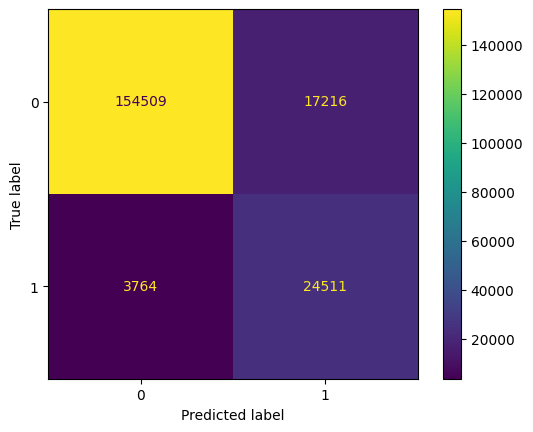

precision: 58.74 +- 0.24
efficiency: 86.69 +- 0.20


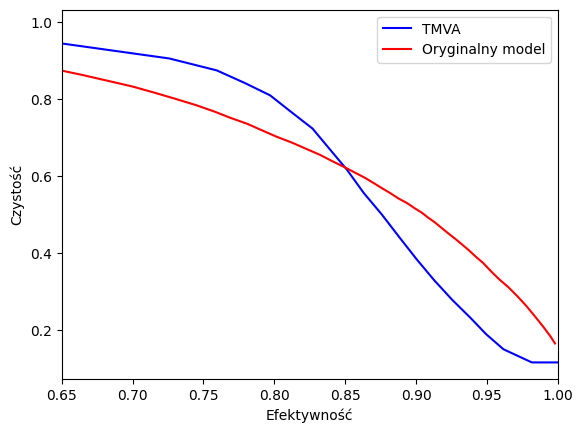

In [12]:
threshold = 0.5 # Narzucony poziom odcięcia

model_results = results_converter(dnn_results, threshold)
confusion_matrix_display(model_results, test_targets)
ROC_display(dnn_results, results_converter, test_targets)

In [13]:
# Funkcja tworząca zależności czystości i efektywności od różnych parametrów użytych do treningu nałożone na rozkład tego parametru w próbie testowej
def histograms(parameter, inputs, targets, results, test_signal_size):
    parameter_dict = {'p_p': [0, 20, (0.29, 2.5), 'pęd całkowity protonu [GeV]', 1], 
                      'p_mu': [3, 20, (0, 7), r'pęd całkowity $\mu^-$ [GeV]', 1], 
                      'alpha': [6, 20, (20, 160), r'kąt $\alpha$ między $\mu^-$ i $p$', 180 / np.pi], 
                      'theta': [7, 20, (0, 90), r'kąt $\theta$ między $\mu^-$ i $\nu$', 180 / np.pi]}
    idx, hist_bins, hist_range, x_label, multiplier = parameter_dict[parameter] # Ustawienia histogramu dla każdego z parametrów
    true_positives = []
    false_positives = []
    false_negatives = []
    signal_hist_inputs = []
    bg_hist_inputs = []

    # Tworzenie list rozkładu parametru wśród wszystkich danych oraz prawdziwego sygnału, fałszyweo sygnału i fałszywego tła
    for event in range(0, test_signal_size):
        signal_hist_inputs.append(inputs[event][0][idx] *  multiplier)
        if results[event] == 1:
            true_positives.append(inputs[event][0][idx] *  multiplier)
        else:
            false_positives.append(inputs[event][0][idx] *  multiplier)

    for event in range(test_signal_size, len(inputs)):
        bg_hist_inputs.append(inputs[event][0][idx] *  multiplier)
        if results[event] == 1:
            false_negatives.append(inputs[event][0][idx] *  multiplier)

    # Tworzenie wykresów i histogramów, niepeweności liczone są ze wzorów dwumianowych
    true_positives_hist, edges = np.histogram(true_positives, bins = hist_bins, range = hist_range)
    false_positives_hist, edges = np.histogram(false_positives, bins = hist_bins, range = hist_range)
    false_negatives_hist, edges = np.histogram(false_negatives, bins = hist_bins, range = hist_range)
    centers = [edges[i] + (edges[i+1] - edges[i]) / 2 for i in range(0, len(edges) - 1)]
    purity = [true_positives_hist[i] / (true_positives_hist[i] + false_negatives_hist[i]) for i in range(len(true_positives_hist))]
    purity_error = [1 / (true_positives_hist[i] + false_negatives_hist[i]) * 
                    np.sqrt(true_positives_hist[i] * (1 - true_positives_hist[i] / (true_positives_hist[i] + false_negatives_hist[i])))
                    for i in range(len(true_positives_hist))]

    efficiency = [true_positives_hist[i] / (true_positives_hist[i] + false_positives_hist[i]) for i in range(len(true_positives_hist))]
    efficiency_error = [1 / (true_positives_hist[i] + false_positives_hist[i]) * 
                    np.sqrt(true_positives_hist[i] * (1 - true_positives_hist[i] / (true_positives_hist[i] + false_positives_hist[i])))
                    for i in range(len(true_positives_hist))]

    fig, ax1 = plt.subplots()
    ax1.set_ylabel('N', color='tab:blue')
    ax1.set_xlabel(x_label)
    ax1.hist(bg_hist_inputs, bins = 50, range = hist_range, label ='Tło w próbie testowej')
    ax1.hist(signal_hist_inputs, bins = 50, range = hist_range, label ='Sygnał w próbie testowej')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.set_xlabel(r'Pęd całkowity $\mu^-$')
    ax2.set_ylabel('Czystość', color='tab:red')
    ax2.errorbar(centers, purity, linestyle = 'none', marker = 'o', color='tab:red', yerr = purity_error)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim([0, 1])
    fig.tight_layout()
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.set_ylabel('N', color='tab:blue')
    ax1.set_xlabel(x_label)
    ax1.hist(bg_hist_inputs, bins = 50, range = hist_range, label ='Tło w próbie testowej')
    ax1.hist(signal_hist_inputs, bins = 50, range = hist_range, label ='Sygnał w próbie testowej')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.set_xlabel(r'Pęd całkowity $\mu^-$')
    ax2.set_ylabel('Efektywność', color='tab:red')
    ax2.errorbar(centers, efficiency, linestyle = 'none', marker = 'o', color='tab:red', yerr = efficiency_error)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim([0, 1])
    fig.tight_layout()
    plt.show()

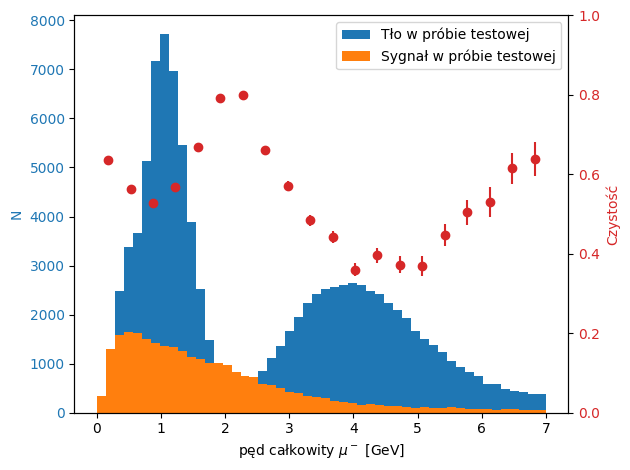

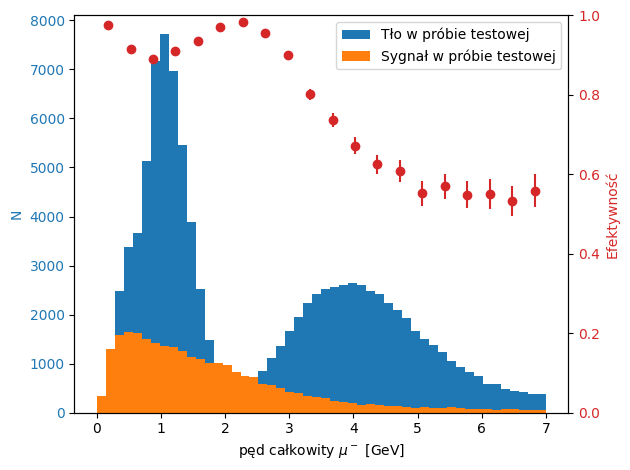

In [14]:
'''
parametry:
pęd całkowity mionu - 'p_mu'
ped całkowity protony - 'p_p'
kąt alpha - 'alpha'
kąt theta - 'theta'
'''
histograms('p_mu', test_all_inputs, test_targets, model_results, test_signal_size)